# === 데이터셋 로딩 ===

In [16]:
import os
import numpy as np

from glob import glob

import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle


def train_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32) / 255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32) / 255
    inp, targ = augmentation(inp, targ)
    return inp, targ


def val_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32) / 255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32) / 255
    return inp, targ


def augmentation(inp, targ):
    inp, targ = random_rot(inp, targ)
    inp, targ = random_flip(inp, targ)
    return inp, targ


def random_rot(inp, targ):
    k = np.random.randint(4)
    inp = np.rot90(inp, k)
    targ = np.rot90(targ, k)
    return inp, targ


def random_flip(inp, targ):
    f = np.random.randint(2)
    if f == 0:
        inp = np.fliplr(inp)
        targ = np.fliplr(targ)
    return inp, targ


def read_dataset_list(path): 
    train_csv = pd.read_csv(os.path.join(path, 'train.csv'))
    test_csv = pd.read_csv(os.path.join(path, 'test.csv'))
    train_all_files = os.path.join(path, 'train') + os.path.sep + train_csv['input_img']
    label_all_files = os.path.join(path, 'label') + os.path.sep + train_csv['label_img']
    train_files = train_all_files[60:].to_numpy()
    label_files = label_all_files[60:].to_numpy()
    val_train_files = train_all_files[:60].to_numpy()
    val_label_files = label_all_files[:60].to_numpy()
    return train_files, label_files, val_train_files, val_label_files


def load_preprocessed_dataset(path, batch_size, image_size=256):
    # 전처리된 npy 포맷 데이터(shape=[image_size, image_size, 3]) 불러오기
    train_input_files = glob(os.path.join(path, f'train_', f'{image_size}', '*.npy'))
    train_label_files = glob(os.path.join(path, f'label_', f'{image_size}', '*.npy'))
    val_input_files = glob(os.path.join(path, f'val_train_', f'{image_size}', '*.npy'))
    val_label_files = glob(os.path.join(path, f'val_label_', f'{image_size}', '*.npy'))
    train_input_files, train_label_files = shuffle(train_input_files, train_label_files, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_input_files, train_label_files))
    train_dataset = train_dataset.map(lambda i1, i2: tf.numpy_function(train_map_func, [i1, i2], [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_input_files, val_label_files))
    val_dataset = val_dataset.map(lambda i1, i2: tf.numpy_function(val_map_func, [i1, i2], [tf.float32, tf.float32]),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return train_dataset, val_dataset


# == UNet++ 모델 생성 ==

In [32]:
import tensorflow as tf

from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, Conv2DTranspose


def conv2d(filters: int):
    return Conv2D(filters=filters, kernel_size=(3, 3),
                  padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.))


def conv2d_transpose(filters: int):
    return Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=(2, 2), padding='same')


def create_unetpp_model(image_size, num_filters=2, dropout_rate=0.25, alpha=0.01):
    model_input = Input((image_size, image_size, 3))
    x00 = conv2d(filters=int(16 * num_filters))(model_input)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU(alpha)(x00)
    x00 = Dropout(dropout_rate)(x00)
    x00 = conv2d(filters=int(16 * num_filters))(x00)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU(alpha)(x00)
    x00 = Dropout(dropout_rate)(x00)
    p0 = MaxPooling2D(pool_size=(2, 2))(x00)

    x10 = conv2d(filters=int(32 * num_filters))(p0)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU(alpha)(x10)
    x10 = Dropout(dropout_rate)(x10)
    x10 = conv2d(filters=int(32 * num_filters))(x10)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU(alpha)(x10)
    x10 = Dropout(dropout_rate)(x10)
    p1 = MaxPooling2D(pool_size=(2, 2))(x10)

    x01 = conv2d_transpose(int(16 * num_filters))(x10)
    x01 = concatenate([x00, x01])
    x01 = conv2d(filters=int(16 * num_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU(alpha)(x01)
    x01 = conv2d(filters=int(16 * num_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU(alpha)(x01)
    x01 = Dropout(dropout_rate)(x01)

    x20 = conv2d(filters=int(64 * num_filters))(p1)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU(alpha)(x20)
    x20 = Dropout(dropout_rate)(x20)
    x20 = conv2d(filters=int(64 * num_filters))(x20)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU(alpha)(x20)
    x20 = Dropout(dropout_rate)(x20)
    p2 = MaxPooling2D(pool_size=(2, 2))(x20)

    x11 = conv2d_transpose(int(16 * num_filters))(x20)
    x11 = concatenate([x10, x11])
    x11 = conv2d(filters=int(16 * num_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU(alpha)(x11)
    x11 = conv2d(filters=int(16 * num_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU(alpha)(x11)
    x11 = Dropout(dropout_rate)(x11)

    x02 = conv2d_transpose(int(16 * num_filters))(x11)
    x02 = concatenate([x00, x01, x02])
    x02 = conv2d(filters=int(16 * num_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU(alpha)(x02)
    x02 = conv2d(filters=int(16 * num_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU(alpha)(x02)
    x02 = Dropout(dropout_rate)(x02)

    x30 = conv2d(filters=int(128 * num_filters))(p2)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU(alpha)(x30)
    x30 = Dropout(dropout_rate)(x30)
    x30 = conv2d(filters=int(128 * num_filters))(x30)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU(alpha)(x30)
    x30 = Dropout(dropout_rate)(x30)
    p3 = MaxPooling2D(pool_size=(2, 2))(x30)

    x21 = conv2d_transpose(int(16 * num_filters))(x30)
    x21 = concatenate([x20, x21])
    x21 = conv2d(filters=int(16 * num_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU(alpha)(x21)
    x21 = conv2d(filters=int(16 * num_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU(alpha)(x21)
    x21 = Dropout(dropout_rate)(x21)

    x12 = conv2d_transpose(int(16 * num_filters))(x21)
    x12 = concatenate([x10, x11, x12])
    x12 = conv2d(filters=int(16 * num_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU(alpha)(x12)
    x12 = conv2d(filters=int(16 * num_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU(alpha)(x12)
    x12 = Dropout(dropout_rate)(x12)

    x03 = conv2d_transpose(int(16 * num_filters))(x12)
    x03 = concatenate([x00, x01, x02, x03])
    x03 = conv2d(filters=int(16 * num_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU(alpha)(x03)
    x03 = conv2d(filters=int(16 * num_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU(alpha)(x03)
    x03 = Dropout(dropout_rate)(x03)

    m = conv2d(filters=int(256 * num_filters))(p3)
    m = BatchNormalization()(m)
    m = LeakyReLU(alpha)(m)
    m = conv2d(filters=int(256 * num_filters))(m)
    m = BatchNormalization()(m)
    m = LeakyReLU(alpha)(m)
    m = Dropout(dropout_rate)(m)

    x31 = conv2d_transpose(int(128 * num_filters))(m)
    x31 = concatenate([x31, x30])
    x31 = conv2d(filters=int(128 * num_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU(alpha)(x31)
    x31 = conv2d(filters=int(128 * num_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU(alpha)(x31)
    x31 = Dropout(dropout_rate)(x31)

    x22 = conv2d_transpose(int(64 * num_filters))(x31)
    x22 = concatenate([x22, x20, x21])
    x22 = conv2d(filters=int(64 * num_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU(alpha)(x22)
    x22 = conv2d(filters=int(64 * num_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU(alpha)(x22)
    x22 = Dropout(dropout_rate)(x22)

    x13 = conv2d_transpose(int(32 * num_filters))(x22)
    x13 = concatenate([x13, x10, x11, x12])
    x13 = conv2d(filters=int(32 * num_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU(alpha)(x13)
    x13 = conv2d(filters=int(32 * num_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU(alpha)(x13)
    x13 = Dropout(dropout_rate)(x13)

    x04 = conv2d_transpose(int(16 * num_filters))(x13)
    x04 = concatenate([x04, x00, x01, x02, x03], axis=3)
    x04 = conv2d(filters=int(16 * num_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU(alpha)(x04)
    x04 = conv2d(filters=int(16 * num_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU(alpha)(x04)
    x04 = Dropout(dropout_rate)(x04)
    output = tf.keras.layers.Conv2D(3, (1, 1), padding='same', activation='tanh')(x04)   # For reconstruction
    return tf.keras.Model(inputs=[model_input], outputs=[output])

# == 모델 학습 ==

In [3]:
# 학습 매개변수
image_size = 256
epoch = 5
batch_size = 2
learning_rate = 0.005

In [4]:
# 전처리 완료된 데이터셋 불러오기
train_dataset, validate_dataset = load_preprocessed_dataset('./Dacon/LG', batch_size, image_size)

# 모델 선언 및 컴파일
model = create_unetpp_model(image_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mae')

In [5]:
# 학습
model.fit(train_dataset, epochs=epoch, validation_data=validate_dataset, callbacks=[
    tf.keras.callbacks.ModelCheckpoint(
        filepath='unetpp_recon_256.h5',
        monitor='val_loss',
        save_best_only=True
    )
])

Epoch 1/5
77870/77870 [==============================] - 3973s 51ms/step - loss: 0.0713 - val_loss: 0.0889
Epoch 2/5
77870/77870 [==============================] - 3968s 51ms/step - loss: 0.0468 - val_loss: 0.0942
Epoch 3/5
77870/77870 [==============================] - 3970s 51ms/step - loss: 0.0429 - val_loss: 0.0866
Epoch 4/5
77870/77870 [==============================] - 3973s 51ms/step - loss: 0.0410 - val_loss: 0.0921
Epoch 5/5
77870/77870 [==============================] - 3976s 51ms/step - loss: 0.0394 - val_loss: 0.0954


# == 모델 추론 ==

In [6]:
model = tf.keras.models.load_model('unetpp_recon_256.h5')

In [22]:
import cv2
from tqdm import tqdm

def predict(img_paths, image_size, stride=32, batch_size=128):
    results = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = img.astype(np.float32)/255
        crop = []
        position = []
        batch_count = 0
        
        result_img = np.zeros_like(img)
        voting_mask = np.zeros_like(img)
        
        for top in tqdm(range(0, img.shape[0], stride)):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([image_size, image_size, 3], np.float32)
                temp = img[top:top + image_size, left:left + image_size,:]
                piece[:temp.shape[0],:temp.shape[1],:] = temp
                crop.append(piece)
                position.append([top,left])
                batch_count += 1
                if batch_count == batch_size:
                    crop = np.array(crop)
                    pred = model(crop)*255
                    crop = []
                    batch_count=0
                    for num, (t,l) in enumerate(position):
                        piece = pred[num]
                        h,w,c = result_img[t:t + image_size, l:l + image_size,:].shape
                        result_img[t:t + image_size, l:l + image_size,:] += piece[:h,:w]
                        voting_mask[t:t + image_size, l:l + image_size, :] += 1
                    position = []
                    
        result_img = result_img / voting_mask
        result_img = result_img.astype(np.uint8)
        results.append(result_img)
        
    return results

In [17]:
train_files, label_files, val_train_files, val_label_files = read_dataset_list('./Dacon/LG')

In [30]:
input_images = [cv2.imread(fn, cv2.IMREAD_COLOR) for fn in val_train_files[:1]]
label_images = [cv2.imread(fn, cv2.IMREAD_COLOR) for fn in val_label_files[:1]]
predicted_images = predict(val_train_files[:1], image_size, 256)

100%|██████████| 10/10 [00:00<00:00, 10.21it/s]
<ipython-input-22-55fef8779ca8>:36: RuntimeWarning: invalid value encountered in true_divide
  result_img = result_img / voting_mask


Text(0.5, 1.0, 'Predicted')

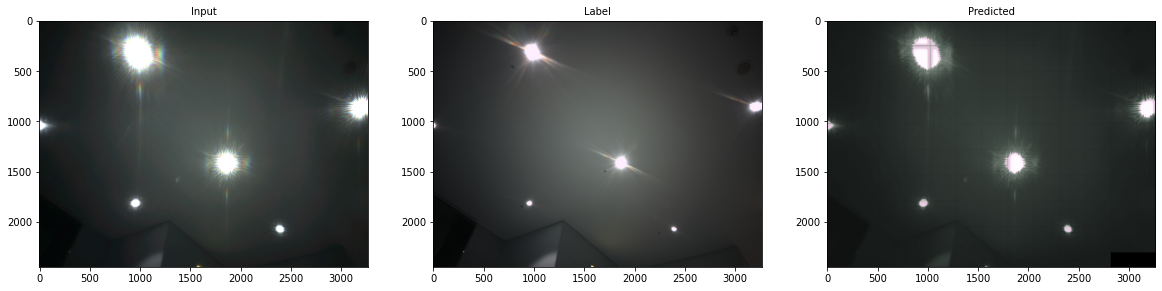

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(input_images[0])
plt.title('Input', fontsize=10)
plt.subplot(1, 3, 2)
plt.imshow(label_images[0])
plt.title('Label', fontsize=10)
plt.subplot(1, 3, 3)
plt.imshow(predicted_images[0])
plt.title('Predicted', fontsize=10)